In [12]:
#LDA Generation
import numpy as np
import random

#MxT
def theta_func(alpha, T, M):
    a = np.full(T, alpha)
    return np.random.dirichlet(a, M)

#TxV
def phi_func(beta, V, T):
    b = np.full(V, beta)
    return np.random.dirichlet(b, T)

def sample(l):
    return np.random.choice(np.arange(0, l.size), p=l)
  
#generate collections    
def generate(collection):
    M = collection[0]
    N = collection[1]
    T = collection[2]
    V = collection[3]
    alpha = collection [4]
    beta  = collection [5]
    
    theta = theta_func(alpha, T, M)
    phi = phi_func(beta, V, T)
    
    documents = []
    for i in range(M):
        topics = [[]]*T
        N_i = random.randint(1, N)
        for j in range(N_i):
            topic = sample(theta[i])
            word = sample(phi[topic])
            temp = topics[topic].copy()
            temp.append(word)
            topics[topic] = temp
        documents.append(topics)
    return documents
            

In [14]:
#3 collections
c1 = [10000, 100, 10, 50000, 0.1, 0.01]
c2 = [100000, 100, 100, 50000, 0.1, 0.01]
c3 = [100000, 10, 1000, 50000, 0.1, 0.01]

In [15]:
c1_gen = generate(c1)
c2_gen = generate(c2)
c3_gen = generate(c3)

In [100]:
def samples(c, n):
    M = c[0]
    N = c[1]
    T = c[2]
    V = c[3]
    alpha = c [4]
    beta  = c [5]
    
    docs = []
    words = []
    
    theta = theta_func(alpha, T, M)
    phi = phi_func(beta, V, T)
    
    for i in range(n):
        random_doc = random.randint(0, c[0])
        docs.append(theta[random_doc])
        
        random_word = random.randint(0, c[3])
        words.append(phi[:, random_word])
        
    return docs, words

In [103]:
c1_samples = samples(c1, 5)
c2_samples = samples(c2, 5)
c3_samples = samples(c3, 5)

In [106]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

def plot_distr(docs, title):
    labels = [f"Topic {i}" for i in range(1, len(docs[0])+1)]
    samples = [f"Sample {i}" for i in range(1, len(docs)+1)]
    data = np.array(docs)
    data = normalize(data, axis=1, norm='l1')
    data_cum = data.cumsum(axis=1)
    colours = plt.get_cmap("viridis")(np.linspace(0, 1, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(9.2, 5))
    
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, colour) in enumerate(zip(labels, colours)):
        width = data[:, i]
        start = data_cum[:, i] - width
        ax.barh(samples, width, left=start, height=0.5, label=colname, color=colour)

    ax.legend(ncol=5, loc=0, fontsize='small', bbox_to_anchor=(1, 1))

    plt.title(title)
    
    plt.show()

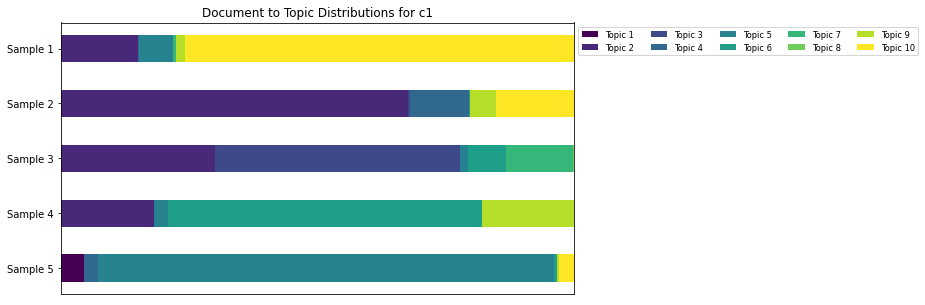

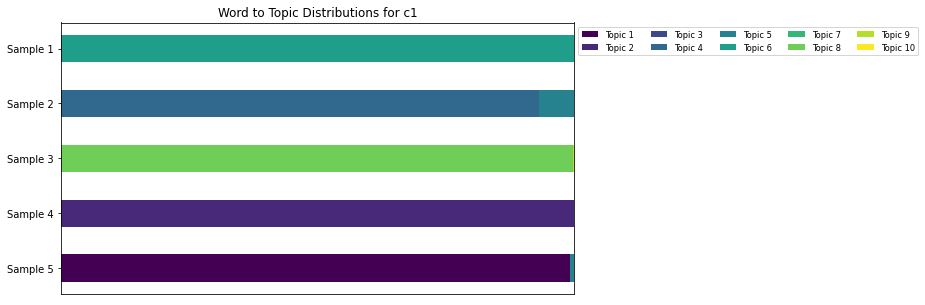

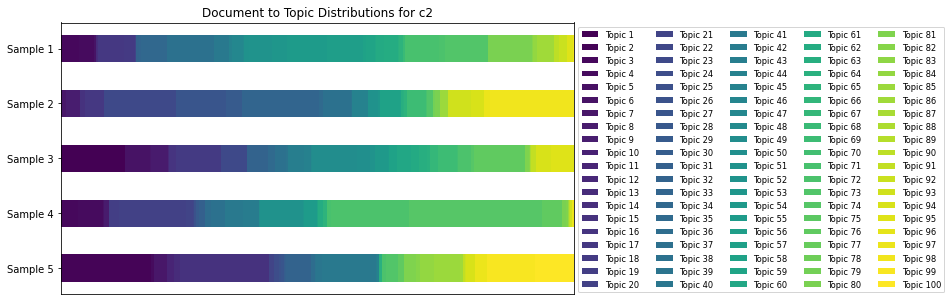

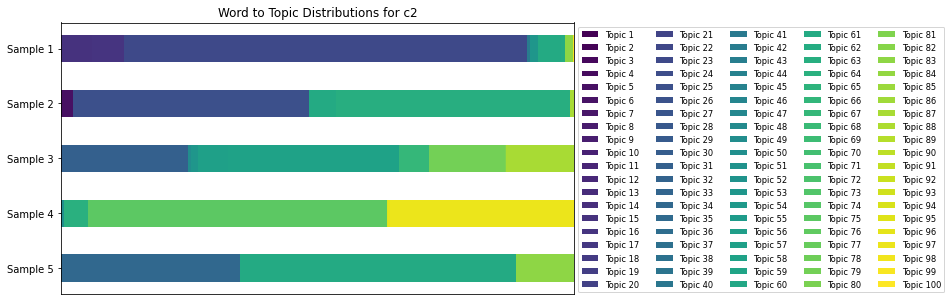

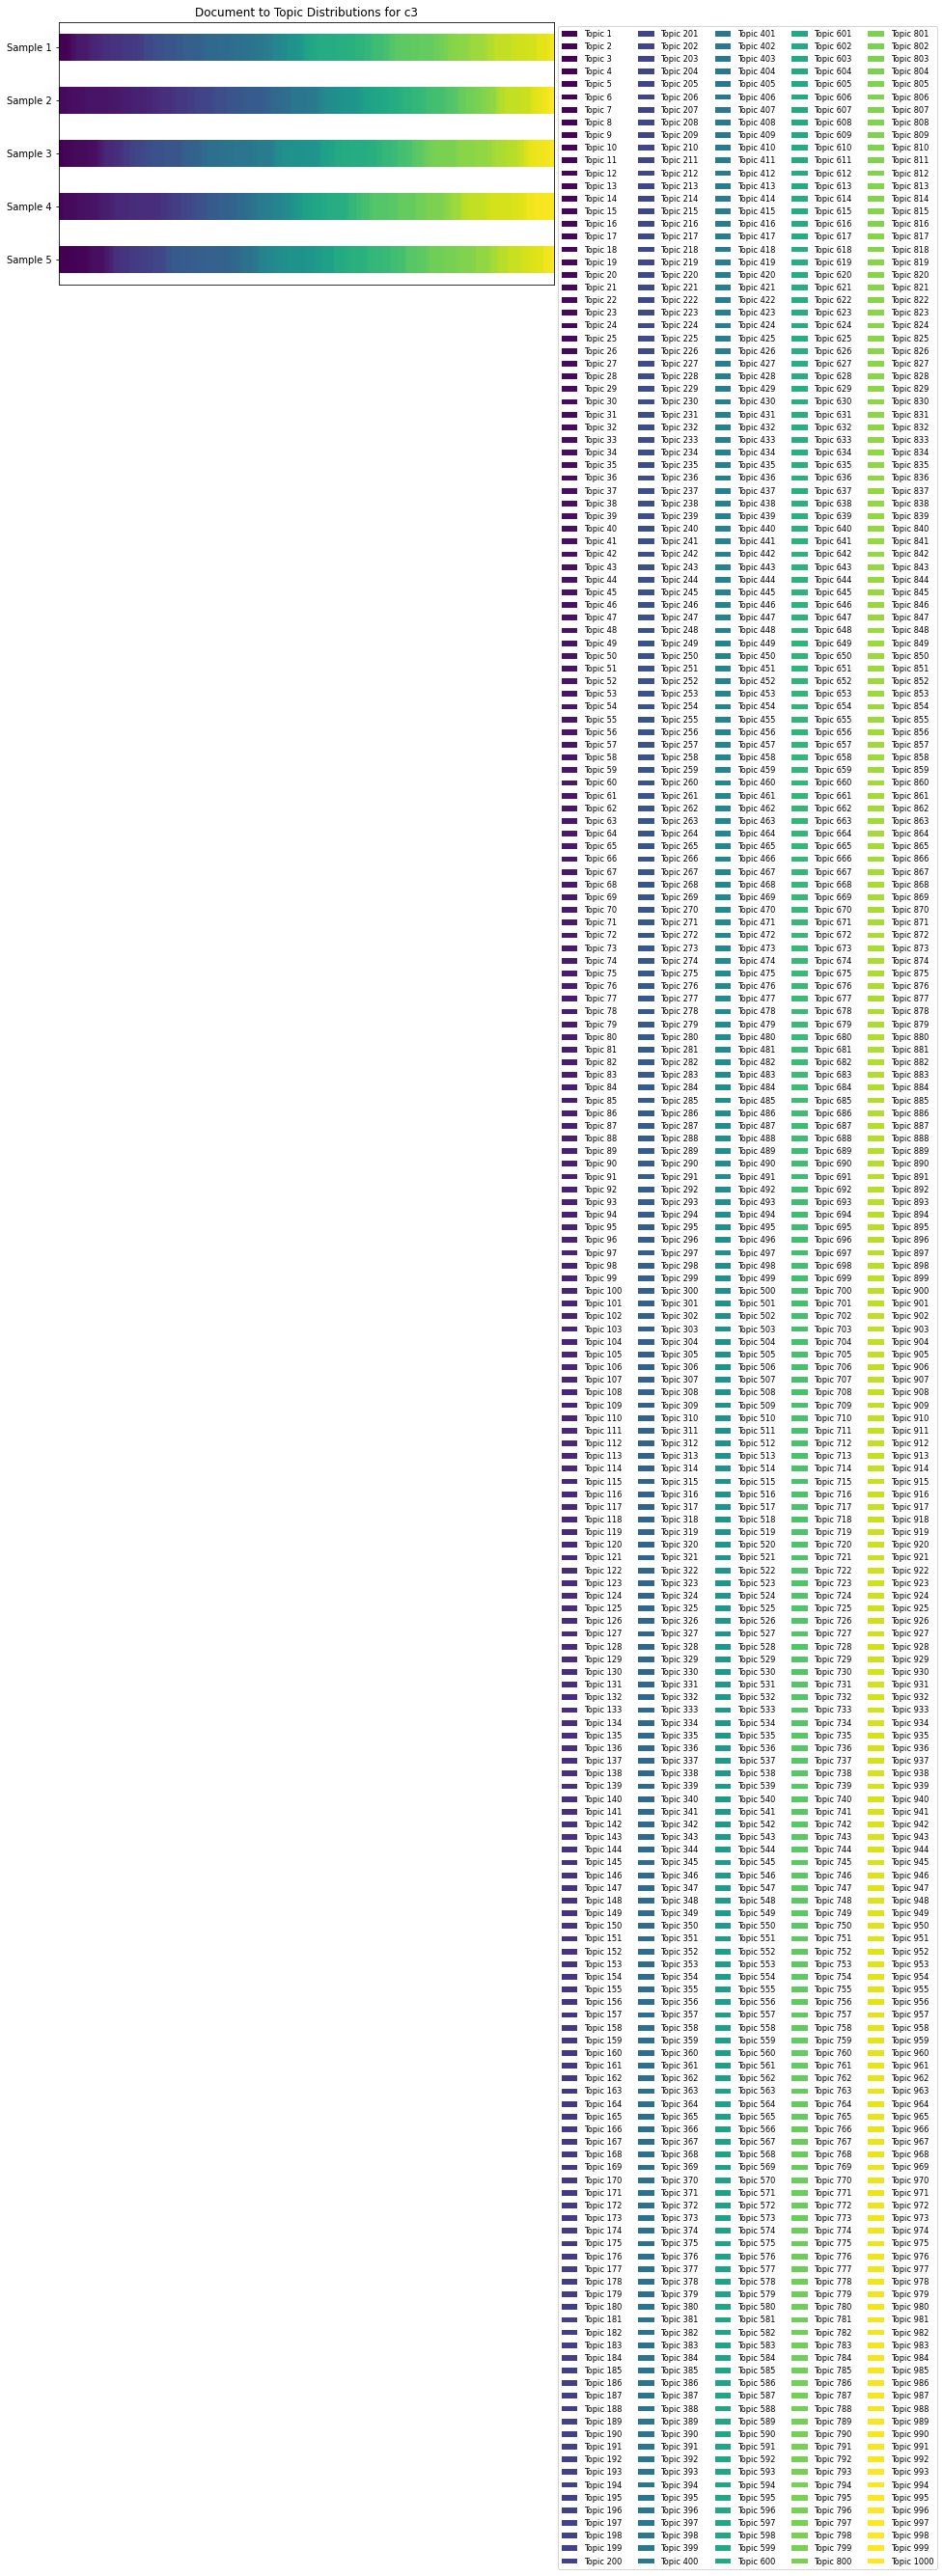

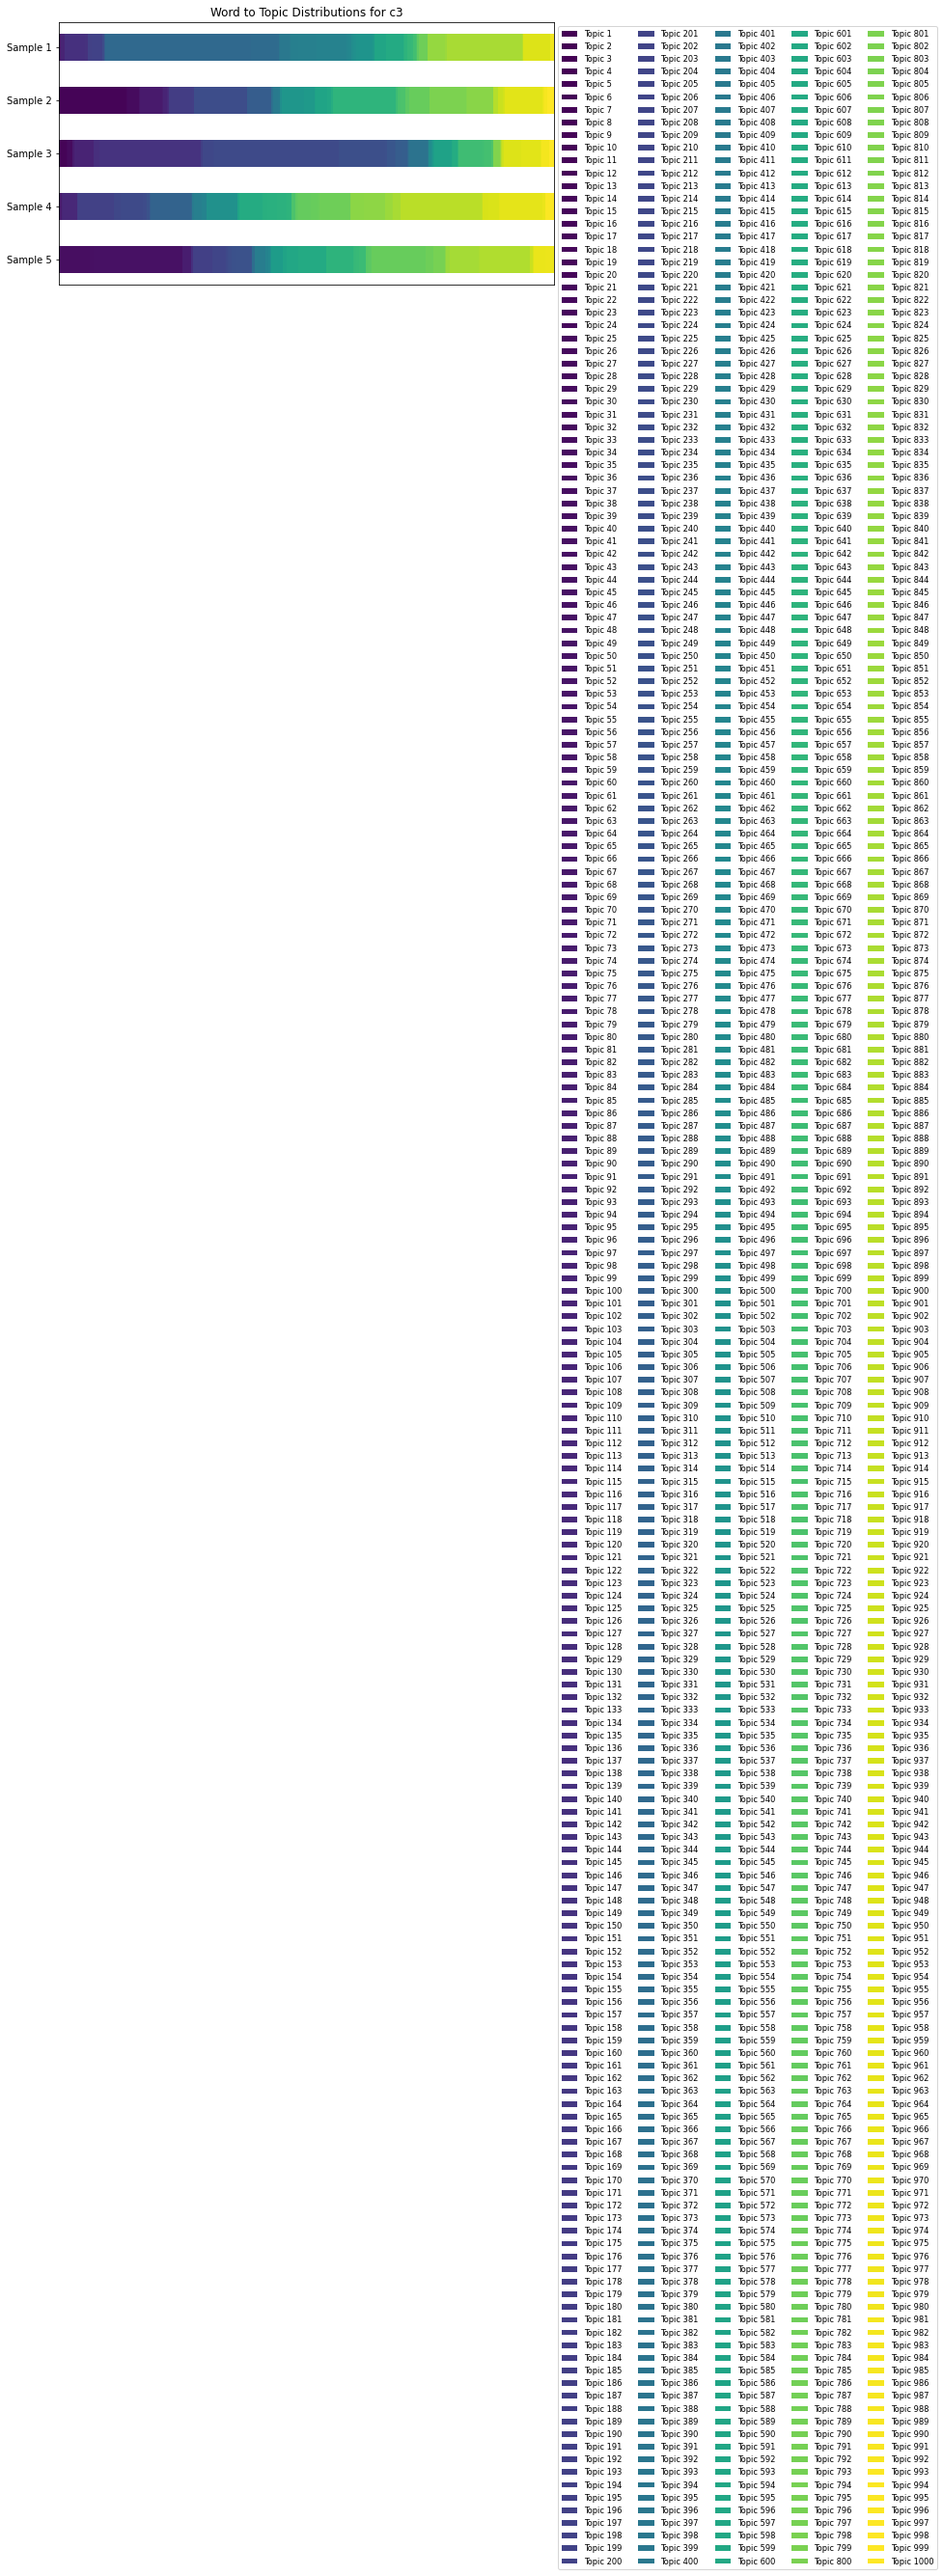

In [107]:
plot_distr(c1_samples[0], 'Document to Topic Distributions for c1')
plot_distr(c1_samples[1], 'Word to Topic Distributions for c1')
plot_distr(c2_samples[0], 'Document to Topic Distributions for c2')
plot_distr(c2_samples[1], 'Word to Topic Distributions for c2')
plot_distr(c3_samples[0], 'Document to Topic Distributions for c3')
plot_distr(c3_samples[1], 'Word to Topic Distributions for c3')

In [20]:
c1_samples_100_1 = samples(c1, 100)
c1_samples_100_2 = samples(c1, 100)
c2_samples_100_1 = samples(c2, 100)
c2_samples_100_2 = samples(c2, 100)
c3_samples_100_1 = samples(c3, 100)
c3_samples_100_2 = samples(c3, 100)

In [26]:
def sigma(x, y):
    result = 0
    x_norm = len(x)
    y_norm = len(x)
    for i in range(x_norm):
        result += (x[i] * y[i])
    return result / (x_norm*y_norm)
    
def avg_sigma(samples_1, samples_2):
    doc_result = 0
    word_result = 0
    for i in range(len(samples_1[0])):
        doc_result += sigma(samples_1[0][i], samples_2[0][i])
        word_result += sigma([float(val)/sum(samples_1[1][i]) for val in samples_1[1][i]], 
                            [float(val)/sum(samples_2[1][i]) for val in samples_2[1][i]])
        
    return doc_result/len(samples_1[0]), word_result/len(samples_1[0])

In [27]:
print(avg_sigma(c1_samples_100_1, c1_samples_100_2))
print(avg_sigma(c2_samples_100_1, c2_samples_100_2))
print(avg_sigma(c3_samples_100_1, c3_samples_100_2))

(0.0011437422605273403, 0.0009349143028698491)
(1.0592551151412672e-06, 5.821727254717156e-07)
(1.0235835203130584e-09, 1.1304749165412805e-09)


In [98]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from collections import Counter

def k_means(data, K):
    kmeans = KMeans(init="random", n_clusters=K, n_init=10, max_iter=300)
    kmeans.fit(data)
    return kmeans

def get_purities(collection):
    M = collection[0]
    N = collection[1]
    T = collection[2]
    V = collection[3]
    alpha = collection [4]
    beta  = collection [5]
    
    theta = theta_func(alpha, T, M)
    
    Ks = [20, 100, 500, 5000]
    result = []
    for K in Ks:
        kmeans = k_means(theta, K)
        clusters = generate_cluster(kmeans.labels_, K, theta)
        result.append(purity(clusters, kmeans.labels_.size))
                      
    return result

def purity(clusters, size):
    result = 0.0
    for cluster in clusters:
        counter = Counter(cluster)
        result += counter.most_common(1)[0][1]
    return result / size
        
def generate_cluster(labels, K, theta):
    result = [[]]*K
    for i in range(labels.size):
        temp = result[labels[i]].copy()
        temp.append(np.argmax(theta[i]))
        result[labels[i]] = temp
    return result

In [92]:
c1_purities = get_purities(c1)

In [93]:
print(c1_purities)

[0.9794, 0.9008, 0.9365, 0.9792]


In [94]:
c2_purities = get_purities(c2)

In [95]:
print(c2_purities)

[0.19582, 0.96388, 0.91648, 0.74206]


In [96]:
c3_purities = get_purities(c3)

In [97]:
print(c3_purities)

[0.02023, 0.1006, 0.42263, 0.785]
